In [11]:
# This generates configuration values with Capytaine.

#!pip install capytaine #uncomment if first time running

import capytaine as cpt
import numpy as np
import matplotlib.pyplot as plt
import copy
from capytaine.bem.airy_waves import airy_waves_potential, airy_waves_velocity, froude_krylov_force


In [2]:
def save_potential_array(title, arr):
    file_path = title + "-real" + ".csv"
    np.savetxt(file_path, np.real(arr), delimiter=",", fmt="%.6e")
    file_path = title + "-imag" + ".csv"
    np.savetxt(file_path, np.imag(arr), delimiter=",", fmt="%.6e")

In [ ]:
def body_from_profile(x,y,z,nphi):
    xyz = np.array([np.array([x/np.sqrt(2),y/np.sqrt(2),z]) for x,y,z in zip(x,y,z)])    # /sqrt(2) to account for the scaling
    body = cpt.FloatingBody(cpt.AxialSymmetricMesh.from_profile(xyz, nphi=nphi))
    return body

def make_face(p1, p2, f_density, t_density):
    zarr = np.linspace(p1[1], p2[1], f_density + 1)
    rarr = np.linspace(p1[0], p2[0], f_density + 1)
    return body_from_profile(rarr, rarr, zarr, t_density)

def get_points(a, d): # These points define the outline of the body
    d_prime = d + [0]
    d_index = 0
    a_index = 0
    pt_lst = [(0, - d[0])]
    for i in range(len(a)):
        pt_lst.append((a[a_index], - d_prime[d_index]))
        d_index +=1
        pt_lst.append((a[a_index], - d_prime[d_index]))
        a_index+=1
    return pt_lst

# compute number of panels along each surface given total number along the outline
def get_f_densities(pt_lst, total_units):
    face_lengths = np.array([])
    for i in range(len(pt_lst) - 1):
        p1, p2 = pt_lst[i], pt_lst[i + 1]
        face_length = abs(p2[0] - p1[0]) + abs(p2[1] - p1[1]) # one of these two values will be zero
        face_lengths = np.append(face_lengths, face_length)
    total_length = sum(face_lengths)
    each_face_densities = np.vectorize(lambda x: max(1, x/total_length * total_units))(face_lengths) # each face needs at least one panel
    remainders = each_face_densities % 1
    each_face_densities = each_face_densities.astype(int)
    remaining_units = total_units - sum(each_face_densities)
    if remaining_units < 0: # high proportion of small faces
        for u in range(remaining_units * -1):
            i = np.argmax(each_face_densities) # cut density from the largest faces
            each_face_densities[i] = (each_face_densities[i]) - 1
    else:
        for u in range(remaining_units): # distribute remaining units where most needed
            i = np.argmax(remainders)
            each_face_densities[i] = (each_face_densities[i]) + 1
            remainders[i] = 0
    assert sum(each_face_densities) == total_units
    return each_face_densities
    
def make_body(a, d, heaving, t_densities, face_units): 
    pts = get_points(a,d)
    f_densities = get_f_densities(pts, face_units)
    faces_and_heaves = []
    panel_ct = 0
    for i in range((len(pts) - 1) // 2):
        p1, p2, p3 = pts[2 * i], pts[2 * i + 1], pts[2 * i + 2]
        # make a horizontal face
        h_face = make_face(p1, p2, f_densities[2 * i], t_densities[i])
        h_heave = heaving[i]
        faces_and_heaves.append((h_face, h_heave))
        panel_ct += f_densities[2 * i] * t_densities[i]
        # make a vertical face
        if p2[1] < p3[1]: # body on left
            region = i
        else: # body on right
            region = i + 1
        v_face = make_face(p2, p3, f_densities[2 * i + 1], t_densities[region])
        faces_and_heaves.append((v_face, heaving[region]))
        panel_ct += f_densities[2 * i + 1] * t_densities[region]
    body = add_heaves(faces_and_heaves)
    return body, panel_ct
    

def add_heaves(faces_and_heaves):
    hcreate = False
    screate = False
    for fh in faces_and_heaves: # Splits list of faces into those that are heaving and those that are not.
        if fh[1]: #fh of the form (face, heaving)
            if not hcreate:
                heaving_body = fh[0]
                hcreate = True
            else:
                heaving_body = heaving_body + fh[0]
        else:
            if not screate:
                still_body = fh[0]
                screate = True
            else:
                still_body = still_body + fh[0]
    if hcreate: # Adds heave dof to the heaving collection
        heaving_body.add_translation_dof(name='Heave')
        if screate:
            return (heaving_body + still_body)
        else:
            return (heaving_body)
    else:
        return (still_body)

###################################
# Solving
solver = cpt.BEMSolver()

def rb_solve(a, d, heaving, t_densities, face_units, m0, h, rho):
    body, panel_count = make_body(a, d, heaving, t_densities, face_units)
    body = body.immersed_part() # removes points above z = 0
    # body.show_matplotlib()
    
    rad_problem = cpt.RadiationProblem(body = body, wavenumber = m0, water_depth = h, rho = rho)
    results = solver.solve(rad_problem, keep_details = True)

    rho = 1023 # density of our special material
    g = 9.81
    omega = np.sqrt(m0*np.tanh(m0*h)*g)

    A = np.array(list(results.added_mass.values()))
    B = np.array(list(results.radiation_damping.values()))
    A_nondim = h**3 / (rho * np.pi * max(a)**3) * A
    B_nondim = h**3 / (omega * rho * np.pi * max(a)**3) * B
    # print(results.added_mass)
    # print(type(results.added_mass))
    # print(results.radiation_damping)
    print("# of Panels: ", panel_count)
    # return A, B, A_nondim, B_nondim
    return A, B, A_nondim, B_nondim

In [8]:
# # Mini Bicylinder
# h = 1.001
# d = [0.25, 0.125]
# a = [0.125, 0.25]
# heaving = [1, 1]

# # Small Bicylinder
# h = 1.001
# d = [0.5, 0.25]
# a = [0.5, 1.0]
# heaving = [1, 1]

# # Big Bicylinder
# h = 1.001
# d = [0.75, 0.5]
# a = [0.5, 0.75]
# heaving = [1, 1]

# # Mini Tricylinder
# h = 2.001
# d = [1.0, 0.5, 0.25]
# a = [0.25, 0.5, 1.0]
# heaving =[1, 1, 1]

# Small Tricylinder
h = 20.0
d = [15, 10, 5]
a = [5, 10, 15]
heaving =[1, 1, 1]

# # Big Tricylinder
# h = 25.0
# d = [20, 15, 10]
# a = [10, 15, 20]
# heaving =[1, 1, 1]

# # Some Bicylinder
# h = 1.001
# d = [0.75, 0.25]
# a = [0.25, 0.75]
# heaving = [1, 1]

t_densities = [50, 50, 50] # number of panels around each cylinder
face_units = 50 # number of panels along the outline of the configuration
m0 = 1
rho = 1023 # density of our special material
config = "config0"

m0_nums = np.concatenate((np.linspace(0.1, 1, 20), np.linspace(1, 6, 30)))

results = [rb_solve(a, d, heaving, t_densities, face_units, m0, h, rho) for m0 in m0_nums]
# results = rb_solve(a, d, heaving, t_densities, face_units, m0, h, rho)

hydro_collector_real_CPT = [res[2].flatten() for res in results]
hydro_collector_imag_CPT = [res[3].flatten() for res in results]

# plt.figure()
# plt.plot(m0_nums,A_nondim, m0_nums,B_nondim, '*-')
# plt.xlabel("Wavenumber m0")
# plt.ylabel("Added mass (kg)")
# plt.show()

# panel_mult = [20,30,40]
# results = [rb_solve(a, d, heaving, t_densities*i, face_units*i, 2, h, rho) for i in panel_mult]

# A_nondim = [res[2].flatten() for res in results]
# B_nondim = [res[3].flatten() for res in results]

# plt.figure()
# plt.plot(panel_mult,A_nondim, panel_mult,B_nondim, '*-')
# plt.xlabel("resolution multiplier")
# plt.ylabel("Added mass (kg)")
# plt.show()



# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500
# of Panels:  2500


[22:52:59] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=0.811, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=0.8105263157894737.                  
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

# of Panels:  2500


[22:53:08] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=0.858, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=0.8578947368421053.                  
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

# of Panels:  2500


[22:53:17] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=0.905, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=0.9052631578947369.                  
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

# of Panels:  2500


[22:53:25] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=0.953, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=0.9526315789473684.                  
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

# of Panels:  2500


[22:53:34] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=1.000, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=1.0.                                 
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

# of Panels:  2500


[22:53:42] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=1.000, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=1.0.                                 
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

# of Panels:  2500


[22:53:47] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=1.172, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=1.1724137931034484.                  
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

# of Panels:  2500


[22:53:56] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=1.345, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=1.3448275862068966.                  
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

# of Panels:  2500


[22:54:04] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=1.517, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=1.5172413793103448.                  
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

# of Panels:  2500


[22:54:12] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=1.690, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=1.6896551724137931.                  
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

# of Panels:  2500


[22:54:20] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=1.862, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=1.8620689655172415.                  
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

# of Panels:  2500


[22:54:29] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=2.034, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=2.0344827586206895.                  
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

# of Panels:  2500


[22:54:38] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=2.207, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=2.206896551724138.                   
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

# of Panels:  2500


[22:54:46] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=2.379, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=2.3793103448275863.                  
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

# of Panels:  2500


[22:54:55] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=2.552, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=2.5517241379310347.                  
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

# of Panels:  2500


[22:55:03] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=2.724, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=2.724137931034483.                   
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

# of Panels:  2500


[22:55:12] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=2.897, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=2.896551724137931.                   
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

# of Panels:  2500


[22:55:20] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=3.069, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=3.0689655172413794.                  
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

# of Panels:  2500


[22:55:29] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=3.241, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=3.241379310344828.                   
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

# of Panels:  2500


[22:55:37] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=3.414, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=3.413793103448276.                   
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

[22:55:42] WARNING  Irregular frequencies for RadiationProblem(body=FloatingBody(...,                              
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=3.414, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The body FloatingBody(...,                                                                     
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might display irregular frequencies for wavenumber=3.413793103448276.     
                    Setting a lid for the floating body is recommended.

# of Panels:  2500


[22:55:46] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=3.586, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=3.586206896551724.                   
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

[22:55:51] WARNING  Irregular frequencies for RadiationProblem(body=FloatingBody(...,                              
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=3.586, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The body FloatingBody(...,                                                                     
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might display irregular frequencies for wavenumber=3.586206896551724.     
                    Setting a lid for the floating body is recommended.

# of Panels:  2500


[22:55:55] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=3.759, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=3.7586206896551726.                  
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

[22:55:59] WARNING  Irregular frequencies for RadiationProblem(body=FloatingBody(...,                              
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=3.759, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The body FloatingBody(...,                                                                     
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might display irregular frequencies for wavenumber=3.7586206896551726.    
                    Setting a lid for the floating body is recommended.

# of Panels:  2500


[22:56:04] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=3.931, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=3.931034482758621.                   
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

[22:56:08] WARNING  Irregular frequencies for RadiationProblem(body=FloatingBody(...,                              
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=3.931, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The body FloatingBody(...,                                                                     
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might display irregular frequencies for wavenumber=3.931034482758621.     
                    Setting a lid for the floating body is recommended.

# of Panels:  2500


[22:56:12] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=4.103, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=4.103448275862069.                   
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

[22:56:17] WARNING  Irregular frequencies for RadiationProblem(body=FloatingBody(...,                              
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=4.103, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The body FloatingBody(...,                                                                     
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might display irregular frequencies for wavenumber=4.103448275862069.     
                    Setting a lid for the floating body is recommended.

# of Panels:  2500


[22:56:21] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=4.276, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=4.275862068965518.                   
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

[22:56:25] WARNING  Irregular frequencies for RadiationProblem(body=FloatingBody(...,                              
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=4.276, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The body FloatingBody(...,                                                                     
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might display irregular frequencies for wavenumber=4.275862068965518.     
                    Setting a lid for the floating body is recommended.

# of Panels:  2500


[22:56:29] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=4.448, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=4.448275862068966.                   
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

[22:56:34] WARNING  Irregular frequencies for RadiationProblem(body=FloatingBody(...,                              
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=4.448, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The body FloatingBody(...,                                                                     
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might display irregular frequencies for wavenumber=4.448275862068966.     
                    Setting a lid for the floating body is recommended.

# of Panels:  2500


[22:56:38] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=4.621, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=4.620689655172415.                   
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

[22:56:42] WARNING  Irregular frequencies for RadiationProblem(body=FloatingBody(...,                              
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=4.621, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The body FloatingBody(...,                                                                     
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might display irregular frequencies for wavenumber=4.620689655172415.     
                    Setting a lid for the floating body is recommended.

# of Panels:  2500


[22:56:46] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=4.793, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=4.793103448275862.                   
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

[22:56:51] WARNING  Irregular frequencies for RadiationProblem(body=FloatingBody(...,                              
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=4.793, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The body FloatingBody(...,                                                                     
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might display irregular frequencies for wavenumber=4.793103448275862.     
                    Setting a lid for the floating body is recommended.

# of Panels:  2500


[22:56:54] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=4.966, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=4.9655172413793105.                  
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

[22:56:59] WARNING  Irregular frequencies for RadiationProblem(body=FloatingBody(...,                              
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=4.966, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The body FloatingBody(...,                                                                     
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might display irregular frequencies for wavenumber=4.9655172413793105.    
                    Setting a lid for the floating body is recommended.

# of Panels:  2500


[22:57:02] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=5.138, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=5.137931034482759.                   
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

[22:57:07] WARNING  Irregular frequencies for RadiationProblem(body=FloatingBody(...,                              
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=5.138, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The body FloatingBody(...,                                                                     
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might display irregular frequencies for wavenumber=5.137931034482759.     
                    Setting a lid for the floating body is recommended.

# of Panels:  2500


[22:57:10] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=5.310, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=5.310344827586207.                   
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

[22:57:15] WARNING  Irregular frequencies for RadiationProblem(body=FloatingBody(...,                              
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=5.310, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The body FloatingBody(...,                                                                     
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might display irregular frequencies for wavenumber=5.310344827586207.     
                    Setting a lid for the floating body is recommended.

# of Panels:  2500


[22:57:18] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=5.483, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=5.482758620689656.                   
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

[22:57:23] WARNING  Irregular frequencies for RadiationProblem(body=FloatingBody(...,                              
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=5.483, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The body FloatingBody(...,                                                                     
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might display irregular frequencies for wavenumber=5.482758620689656.     
                    Setting a lid for the floating body is recommended.

# of Panels:  2500


[22:57:27] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=5.655, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=5.655172413793104.                   
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

[22:57:32] WARNING  Irregular frequencies for RadiationProblem(body=FloatingBody(...,                              
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=5.655, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The body FloatingBody(...,                                                                     
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might display irregular frequencies for wavenumber=5.655172413793104.     
                    Setting a lid for the floating body is recommended.

# of Panels:  2500


[22:57:35] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=5.828, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=5.827586206896552.                   
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

[22:57:40] WARNING  Irregular frequencies for RadiationProblem(body=FloatingBody(...,                              
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=5.828, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The body FloatingBody(...,                                                                     
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might display irregular frequencies for wavenumber=5.827586206896552.     
                    Setting a lid for the floating body is recommended.

# of Panels:  2500


[22:57:44] WARNING  Mesh resolution for RadiationProblem(body=FloatingBody(...,                                    
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=6.000, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The resolution of the mesh of the body FloatingBody(...,                                       
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might be insufficient for wavenumber=6.0.                                 
                    This warning appears because the largest panel of this mesh has radius 0.992 > wavelength/8.

[22:57:48] WARNING  Irregular frequencies for RadiationProblem(body=FloatingBody(...,                              
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh"), wavenumber=6.000, water_depth=20.0, radiating_dof='Heave', rho=1023.0):  
                    The body FloatingBody(...,                                                                     
                    name="axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh+axisymmetric_mesh
                    +axisymmetric_mesh") might display irregular frequencies for wavenumber=6.0.                   
                    Setting a lid for the floating body is recommended.

# of Panels:  2500


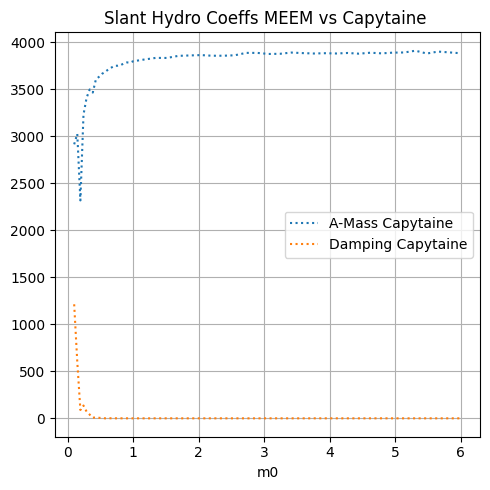

In [10]:
# Create the plots
plt.figure(figsize=(5,5))
plt.plot(m0_nums, hydro_collector_real_CPT, label='A-Mass Capytaine',  linestyle=':')
plt.plot(m0_nums, hydro_collector_imag_CPT, label='Damping Capytaine',  linestyle=':') 

plt.xlabel('m0')
plt.ylabel('')
plt.title('Slant Hydro Coeffs MEEM vs Capytaine ')
plt.legend(loc='best')
plt.grid(True)
# plt.ylim(-0.02, 1.5)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure()
plt.plot(panel_mult,A_nondim)
plt.xlabel("resolution multiplier")
plt.ylabel("Added mass (kg)")
plt.show()


In [33]:
# print(A_nondim)
# print(B_nondim)

# Extract values from NumPy arrays
flat_list1 = [x.item() for x in A_nondim]
flat_list2 = [x.item() for x in B_nondim]

# Convert to MATLAB-style string
matlab_list1 = "pyCapytaine_mu_nondim = [" + " ".join(map(str, flat_list1)) + "];"
matlab_list2 = "pyCapytaine_lambda_nondim = [" + " ".join(map(str, flat_list2)) + "];"

# Print MATLAB code
print(matlab_list1)
print(matlab_list2)




pyCapytaine_mu_nondim = [2.830145849023367 0.9612560526812186 0.8905066241476098 0.8359458082233631 0.7912857868071146 0.7533229802963917 0.7204698827928295 0.6916910312622299 0.6661552619787712 0.6421106760245646 0.6223137557048558 0.6030660839465698 0.5855513266401267 0.5694765724760519 0.554979382443524 0.5415464053207449 0.5287830790940118 0.5173816249796778 0.5068599399987725 0.4969994841801853 0.49699948418018536 0.4667635957623288 0.4437117570764719 0.4270109908279275 0.4142350105253891 0.4049580699850535 0.39869461087013514 0.39521584839375407 0.3923597835658513 0.3918483461850354 0.392026154471042 0.3930295113051248 0.39531194843794637 0.3976387451187765 0.4003451873995892 0.40333605084418994 0.40636894734830675 0.40974943492730914 0.41309994091103014 0.41640497920705927 0.4200291288568071 0.42369734357250677 0.4279653204864854 0.4318256362224606 0.44033761471307736 0.451403429950912 0.31216588589121524 0.4107556300502315 0.4263371597329694 0.429720394605228];
pyCapytaine_lamb

In [ ]:
list1 = np.linspace(0.1, 1, 20)
list2 = np.linspace(1, 3, 10)
list3 = np.concatenate((list1, list2))
print(list1)
print(list2)
print(list3)

In [ ]:

print(m0_nums)

In [ ]:
#staircase  - compound cylinder
h = 1.5
d = [1.1, 0.85, 0.75, 0.4, 0.15]
a = [0.3, 0.5, 1, 1.2, 1.6]
heaving = [1, 1, 1, 1, 1]
t_densities = [30, 50, 100, 120, 160]
face_units = 93
m0 = 1
rho = 1023
config = "config1"


result, panel_count = rb_solve(a, d, heaving, t_densities, face_units, m0, h, rho)

In [ ]:
#tall  - compound cylinder
h = 100
d = [29, 7, 4]
a = [3, 5, 10]
heaving = [1, 1, 1]
t_densities = [30, 50, 100]
face_units = 110
m0 = 1
rho = 1023
config = "config2"

result, panel_count = rb_solve(a, d, heaving, t_densities, face_units, m0, h, rho)

In [ ]:
#indents  - compound cylinder
h = 1.9
d = [0.5, 0.7, 0.8, 0.2, 0.5]
a = [0.3, 0.5, 1, 1.2, 1.6]
heaving = [1, 1, 1, 1, 1]
t_densities = [30, 50, 100, 120, 160]
face_units = 105
m0 = 1
rho = 1023
config = "config3"

result, panel_count = rb_solve(a, d, heaving, t_densities, face_units, m0, h, rho)

In [ ]:
#original - only outer heaving
h = 1.001
d = [0.5, 0.25]
a = [0.5, 1]
heaving = [0, 1]
t_densities = [50, 100]
face_units = 90
m0 = 1
rho = 1023
config = "config4"

result, panel_count = rb_solve(a, d, heaving, t_densities, face_units, m0, h, rho)

In [ ]:
#original - only inner heaving
h = 1.001
d = [0.5, 0.25]
a = [0.5, 1]
heaving = [1, 0]
t_densities = [50, 100]
face_units = 90
m0 = 1
rho = 1023
config = "config5"

result, panel_count = rb_solve(a, d, heaving, t_densities, face_units, m0, h, rho)

In [ ]:
#tall  - spar not heaving
h = 100
d = [29, 7, 4]
a = [3, 5, 10]
heaving = [0, 1, 1]
t_densities = [30, 50, 100]
face_units = 110
m0 = 1
rho = 1023
config = "config6"

result, panel_count = rb_solve(a, d, heaving, t_densities, face_units, m0, h, rho)

In [ ]:
# Get potentials
# Define the ranges for R and Z
R_range = np.linspace(0.0, 2*a[-1], num=50)
theta_range = np.linspace(-np.pi, np.pi, num=4)
Z_range = np.linspace(0, -h, num=50) #h

# Create mesh grids for R, theta, and Z
R, theta, Z = np.meshgrid(R_range, theta_range, Z_range, indexing='ij')

# Convert cylindrical coordinates to Cartesian coordinates for capytaine
X = R * np.cos(theta)
Y = R * np.sin(theta)
Z = Z
# Create an array of shape (N, 3)
points = np.zeros((R.size, 3))

# Assign the values of R, Z, and y to the array
points[:, 0] = X.ravel()
points[:, 1] = Y.ravel()
points[:, 2] = Z.ravel()
#need cartesian here
phi_inc = solver.compute_potential(points,result) #rad problem

regions = []
regions.append((R <= a[0]) & (Z > -d[0]))
for i in range(1, len(a)):
    regions.append((R > a[i-1]) & (R <= a[i]) & (Z > -d[i]))
regions.append(R > a[-1])

# Apply masks to create a blank plot in specified regions
phi_inc = phi_inc.reshape((50,4,50))

for i in range(len(a)):
  phi_inc[regions[i]] = np.nan



In [ ]:
# Get velocities
vel_inc = solver.compute_velocity(points,result)
velx_inc = vel_inc[:,0].reshape((50,4,50))
vely_inc = vel_inc[:,1].reshape((50,4,50))
velz_inc = vel_inc[:,2].reshape((50,4,50))
for i in range(len(a)):
  velx_inc[regions[i]] = np.nan
  vely_inc[regions[i]] = np.nan
  velz_inc[regions[i]] = np.nan

In [ ]:
# Plot potentials and velocities
# The slicing limits the y-value to 0 because we only care about the x-z (r-z) plane.
plt.contourf(R[:, 0, :], Z[:, 0, :], phi_inc[:, 0, :], cmap='viridis', levels = 50)
plt.colorbar(label='Potential')
plt.contour(R[:, 0, :], Z[:, 0, :], phi_inc[:, 0, :], colors='black', linestyles='solid', linewidths=0.05,levels=50)

# Add labels and title
plt.xlabel('R')
plt.ylabel('Z')
plt.title('Contour Plot of Re(Potential) using BEM')

plt.show()

imag_phi_inc = np.imag(phi_inc[:, 0, :])

nan_mask = np.isnan(np.real(phi_inc[:, 0, :]))

np.imag(phi_inc[:, 0, :])[nan_mask] = np.nan

plt.contourf(R[:, 0, :], Z[:, 0, :], imag_phi_inc, cmap='viridis', levels = 50)
plt.colorbar(label='Potential')
plt.contour(R[:, 0, :], Z[:, 0, :], imag_phi_inc, colors='black', linestyles='solid', linewidths=0.05,levels=50)


# Add labels and title
plt.xlabel('R')
plt.ylabel('Z')
plt.title('Contour Plot of Im(Potential) using BEM')

plt.show()

def plot_vel(data, title):
  plt.contourf(R[:, 0, :], Z[:, 0, :], data[:, 0, :], cmap='viridis', levels = 50)
  plt.colorbar(label='V')
  plt.contour(R[:, 0, :], Z[:, 0, :], data[:, 0, :], colors='black', linestyles='solid', linewidths=0.05,levels=50)

  # Add labels and title
  plt.xlabel('R')
  plt.ylabel('Z')
  plt.title(title)

  plt.show()

nan_mask = np.isnan(np.real(velx_inc))

velx_imag = np.imag(velx_inc)
velz_imag = np.imag(velz_inc)

velx_imag[nan_mask] = np.nan
velz_imag[nan_mask] = np.nan

plot_vel(velx_inc, "Contour Plot of Re(Vx) using BEM")
plot_vel(velx_imag, "Contour Plot of Im(Vx) using BEM")
plot_vel(velz_inc, "Contour Plot of Re(Vz) using BEM")
plot_vel(velz_imag, "Contour Plot of Im(Vz) using BEM")


In [ ]:
save_potential_array(config, phi_inc[:, 0, :])
# WARNING: This overwrites existing files with the same name. Ensure that <config> is correct before running.